# N starvation 

## Which N sources allow MED4 to grow

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools

In [159]:
from cobra.flux_analysis import flux_variability_analysis

In [160]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [161]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   #["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   #["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [162]:
# Calculate Vmax
N_growth_yield = 0.1166 #gDW/mmol NH3
Km_ammonium = 0.35*1e-3 #mM
observed_growth_rate = 0.4 #/day
observed_death_rate = 0.1 #/day
gross_growth_rate = observed_death_rate + observed_growth_rate
gross_gr_hour = gross_growth_rate/24
N_conc = 0.1 #mM

def Vmax(Km, conc, N_yield, growth_rate):
    return (growth_rate/N_yield)*(Km+conc)/conc

print("Ammonium Vmax: ", Vmax(Km_ammonium, N_conc, N_growth_yield, gross_gr_hour))
#print("Ammonium Vmax: ", Vmax(Km_ammonium, N_conc, N_growth_yield, observed_growth_rate/24))

Ammonium Vmax:  0.17929888507718697


# Import model and identify yields

In [163]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [164]:
model = cobra.io.read_sbml_model(model_fpath)

In [165]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [166]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [167]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [168]:
model

Name,COBRAModel
Memory address,0x07f97c442f730
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [169]:
model.metabolites.get_by_id('Carbamate[c]')

Metabolite identifier,Carbamate[c]
Name,Carbamate
Memory address,0x7f97c4440c40
Formula,CH3NO2
Compartment,c
In 4 reaction(s),"R03546, R10949, R07316, R01395"


In [170]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,11
cache_directory,Path for the model cache,/home/oweissberg/.cache/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


In [171]:
model.reactions.get_by_id('PyruvateEX')

Reaction identifier,PyruvateEX
Name,PyruvateEX
Memory address,0x7f97c3d30490
Stoichiometry,Pyruvate[e] --> Pyruvate[e] -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [172]:
model.reactions.get_by_id('AmmoniaEX')

Reaction identifier,AmmoniaEX
Name,Ammonia Exchange
Memory address,0x7f97c3d855b0
Stoichiometry,Ammonia[e] <=> Ammonia <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [173]:
model.reactions.get_by_id('LightEX')

Reaction identifier,LightEX
Name,Light Exchange
Memory address,0x7f97c3d85310
Stoichiometry,Photon[e] <-- Photon <--
GPR,
Lower bound,-150
Upper bound,0


In [174]:
model.reactions.get_by_id('BIOMASS')

Reaction identifier,BIOMASS
Name,Biomass formation
Memory address,0x7f97c4127c70
Stoichiometry,104.0 ATP[c] + 0.0324116276714271 BioPool[c] + 0.0268408791654006 Bmineral[c] + 0.0559910868023904 Cell_wall[c] + 0.00111921401802897 Free_nucleic_acids[c] + 104.0 H2O[c] + 0.649245416793275... 104.0 ATP + 0.0324116276714271 BioPool + 0.0268408791654006 Trace metals and minerals + 0.0559910868023904 Cell wall Biomass precursor + 0.00111921401802897 Free nucleic acids + 104.0 H2O +...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [175]:
from cobra.flux_analysis import production_envelope


In [176]:
model.medium

{'AmmoniaEX': 1000.0,
 'CadmiumEX': 1000.0,
 'CalciumEX': 1000.0,
 'ChlorideEX': 1000.0,
 'CobaltEX': 1000.0,
 'CopperEX': 1000.0,
 'FAKEOrthophosphateEX': 1000.0,
 'H2OEX': 1000.0,
 'HCO3EXcar': 8,
 'HEX': 1000.0,
 'IronEX': 1000.0,
 'LightEX': 150,
 'MagnesiumEX': 1000.0,
 'MolybdenumEX': 1000.0,
 'O2EX': 1000.0,
 'PotassiumEX': 1000.0,
 'SelenateEX': 1000.0,
 'SodiumEX': 1000.0,
 'StrontiumEX': 1000.0,
 'SulfateEX': 1000.0,
 'ZincEX': 1000.0,
 'H2O2EX': 1000.0}

In [177]:
# try to each exchange one by one
results = list()

def _check_medium(met1, met2=None):
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.optimize()
        return {'uptake' : met1, 'objective_value' : solution.objective_value}
results = [_check_medium(met) for met in exchange_ids]        

In [178]:
df = pd.DataFrame(results)

In [179]:
df_growing = df.loc[(df.objective_value > 1e-5), 
                    ['uptake','objective_value']
                   ].nlargest(n=1000, columns='objective_value').reset_index(drop=True)

In [180]:
df_growing

,uptake,objective_value
0,GuanosineEX,1.239447
1,L_AspartateEX,0.238582
2,GlutathioneEX,0.137239
3,L_GlutamineEX,0.121923
4,L_SerineEX,0.118972
5,L_CystineEX,0.116452
6,L_AlanineEX,0.116452
7,L_LeucineEX,0.103996
8,GlycineEX,0.101626
9,UreaEX,0.098462


In [182]:
# open all additional mediums (all those that do not facilitate growth by themselves)
not_open_boundary_ids = [i for i in boundary_ids if (i not in model.medium) and (i not in df_growing.uptake.values)]
with model:
    medium = model.medium
    medium["AmmoniaEX"] = 0.0
    for i in not_open_boundary_ids:
        medium[i] = 1000.0
    model.medium = medium
    solution = model.optimize()
    print(model.summary())


Objective
1.0 BIOMASS = 1.2838897935641987e-15

Uptake
------
 Metabolite   Reaction   Flux  C-Number  C-Flux
 Ethanol[e]  EthanolEX 0.1579         0   0.00%
Fumarate[e] FumarateEX 0.1579         0   0.00%
Glycogen[e] GlycogenEX 0.1579         6 100.00%
  Oxygen[e]       O2EX 0.8686         0   0.00%

Secretion
---------
Metabolite  Reaction    Flux  C-Number  C-Flux
    CO2[e]     CO2EX -0.3159         1 100.00%
Citrate[e] CitrateEX -0.1579         0   0.00%
Formate[e] FormateEX -0.6317         0   0.00%
    H2O[e]     H2OEX -0.3159         0   0.00%



In [183]:
def _force_feeding(met1):
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        model.reactions.get_by_id(met1).upper_bound = -1e-5
        model.reactions.BIOMASS.upper_bound = 1e-1
        solution = model.optimize()
        print(met1, model.summary())
        fluxes = flux_variability_analysis(model, model.boundary, loopless=True, fraction_of_optimum=0.9, processes=11)
        fluxes['uptake'] = met1
        return fluxes
fluxes_df_list = [_force_feeding(met1) for met1 in df_growing['uptake']]

GuanosineEX Objective
1.0 BIOMASS = 0.1

Uptake
------
         Metabolite             Reaction      Flux  C-Number  C-Flux
         Cadmium[e]            CadmiumEX 4.827E-06         0   0.00%
  Calcium_cation[e]            CalciumEX  0.002676         0   0.00%
    Chloride_ion[e]           ChlorideEX   0.02379         0   0.00%
      Cobalt_ion[e]             CobaltEX 0.0001552         0   0.00%
          Copper[e]             CopperEX 8.734E-06         0   0.00%
  Orthophosphate[e] FAKEOrthophosphateEX   0.03633         0   0.00%
       Guanosine[e]          GuanosineEX     3.743         0   0.00%
            HCO3[e]            HCO3EXcar    0.6454         1 100.00%
             Fe2[e]               IronEX 0.0003232         0   0.00%
          Photon[e]              LightEX   0.01817         0   0.00%
Magnesium_cation[e]          MagnesiumEX   0.01589         0   0.00%
      Molybdenum[e]         MolybdenumEX 6.895E-07         0   0.00%
          Oxygen[e]                 O2EX     2.0

L_GlutamineEX Objective
1.0 BIOMASS = 0.1

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-06         0  0.00%
  Calcium_cation[e]            CalciumEX  0.002676         0  0.00%
    Chloride_ion[e]           ChlorideEX   0.02379         0  0.00%
      Cobalt_ion[e]             CobaltEX 0.0001552         0  0.00%
          Copper[e]             CopperEX 8.734E-06         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX   0.03633         0  0.00%
            HCO3[e]            HCO3EXcar     4.507         1 58.16%
             Fe2[e]               IronEX 0.0003232         0  0.00%
     L_Glutamine[e]        L_GlutamineEX    0.6483         5 41.84%
          Photon[e]              LightEX     65.53         0  0.00%
Magnesium_cation[e]          MagnesiumEX   0.01589         0  0.00%
      Molybdenum[e]         MolybdenumEX 6.895E-07         0  0.00%
               K[e]          PotassiumEX  0.009516         

L_AlanineEX Objective
1.0 BIOMASS = 0.1

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.827E-06         0  0.00%
  Calcium_cation[e]            CalciumEX  0.002676         0  0.00%
    Chloride_ion[e]           ChlorideEX   0.02379         0  0.00%
      Cobalt_ion[e]             CobaltEX 0.0001552         0  0.00%
          Copper[e]             CopperEX 8.734E-06         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX   0.03633         0  0.00%
            HCO3[e]            HCO3EXcar     4.456         1 13.56%
             Fe2[e]               IronEX 0.0003232         0  0.00%
       L_Alanine[e]          L_AlanineEX     9.467         3 86.44%
          Photon[e]              LightEX     39.72         0  0.00%
Magnesium_cation[e]          MagnesiumEX   0.01589         0  0.00%
      Molybdenum[e]         MolybdenumEX 6.895E-07         0  0.00%
               K[e]          PotassiumEX  0.009516         0 

UreaEX Objective
1.0 BIOMASS = 0.09846248800237174

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.752E-06         0  0.00%
  Calcium_cation[e]            CalciumEX  0.002635         0  0.00%
    Chloride_ion[e]           ChlorideEX   0.02343         0  0.00%
      Cobalt_ion[e]             CobaltEX 0.0001528         0  0.00%
          Copper[e]             CopperEX 8.599E-06         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX   0.03577         0  0.00%
            HCO3[e]            HCO3EXcar     5.342         1 92.59%
             Fe2[e]               IronEX 0.0003182         0  0.00%
          Photon[e]              LightEX     73.12         0  0.00%
Magnesium_cation[e]          MagnesiumEX   0.01565         0  0.00%
      Molybdenum[e]         MolybdenumEX 6.789E-07         0  0.00%
               K[e]          PotassiumEX   0.00937         0  0.00%
        Selenate[e]           SelenateEX  0.007518

L_ArginineEX Objective
1.0 BIOMASS = 0.09479172165766424

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 4.575E-06         0  0.00%
  Calcium_cation[e]            CalciumEX  0.002537         0  0.00%
    Chloride_ion[e]           ChlorideEX   0.02255         0  0.00%
      Cobalt_ion[e]             CobaltEX 0.0001471         0  0.00%
          Copper[e]             CopperEX 8.279E-06         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX   0.03444         0  0.00%
            HCO3[e]            HCO3EXcar     5.281         1 70.12%
             Fe2[e]               IronEX 0.0003064         0  0.00%
      L_Arginine[e]         L_ArginineEX     0.375         6 29.88%
          Photon[e]              LightEX     72.37         0  0.00%
Magnesium_cation[e]          MagnesiumEX   0.01506         0  0.00%
      Molybdenum[e]         MolybdenumEX 6.536E-07         0  0.00%
               K[e]          PotassiumEX  0.

GuanineEX Objective
1.0 BIOMASS = 0.05263547301287259

Uptake
------
         Metabolite             Reaction      Flux  C-Number  C-Flux
         Cadmium[e]            CadmiumEX  2.54E-06         0   0.00%
  Calcium_cation[e]            CalciumEX  0.001409         0   0.00%
    Chloride_ion[e]           ChlorideEX   0.01252         0   0.00%
      Cobalt_ion[e]             CobaltEX 8.168E-05         0   0.00%
          Copper[e]             CopperEX 4.597E-06         0   0.00%
  Orthophosphate[e] FAKEOrthophosphateEX   0.01912         0   0.00%
         Guanine[e]            GuanineEX    0.4438         0   0.00%
            HCO3[e]            HCO3EXcar      5.04         1 100.00%
             Fe2[e]               IronEX 0.0001701         0   0.00%
          Photon[e]              LightEX     61.67         0   0.00%
Magnesium_cation[e]          MagnesiumEX  0.008364         0   0.00%
      Molybdenum[e]         MolybdenumEX 3.629E-07         0   0.00%
               K[e]          Potas

In [186]:
force_feeding_df = pd.concat(fluxes_df_list)

In [187]:
force_feeding_df.index = force_feeding_df.index.set_names(['secretion'])
force_feeding_df = force_feeding_df.reset_index()
force_feeding_df.head()

,secretion,minimum,maximum,uptake
0,AminosugarsEX,0.0,0.0,GuanosineEX
1,FAKEAAEX,0.0,0.0,GuanosineEX
2,FAKEABPEX,0.0,0.0,GuanosineEX
3,FAKEacpEX,0.0,0.0,GuanosineEX
4,FAKEApoacpEX,0.0,0.0,GuanosineEX


In [188]:
force_feeding_df.loc[force_feeding_df.maximum > 1e-5, 'secretion']

8                                     B12EX
9                                  BiotinEX
11                         GlycolaldehydeEX
14                               MethanolEX
16      SAdenosyl4methylthio2oxobutanoateEX
17                    SMethyl5thioDriboseEX
21                                   tRNAEX
22                              GlycolateEX
23                                AmmoniaEX
24                                BiomassEX
25                             CadaverineEX
29                                    CO2EX
35                               GlycogenEX
36                                    H2OEX
37                                    H2SEX
39                                      HEX
44                                     O2EX
48                               SpermineEX
51                            ThiosulfateEX
52                                   UreaEX
54                              L_AlanineEX
55                             L_ArginineEX
56                           L_A

In [190]:
force_feeding_df.loc[force_feeding_df.maximum > 1e-3].groupby('secretion').minimum.count()

secretion
4_AminobenzoateEX                      16
4_Methyl_2_oxopentanoateEX             16
5_MethylthioadenosineEX                16
AcetateEX                              16
AdenineEX                              16
AmmoniaEX                              15
B12EX                                  16
BiomassEX                              16
BiotinEX                               16
CO2EX                                  16
CadaverineEX                           16
CitrateEX                              16
DethiobiotinEX                         16
EthanolEX                              16
FormateEX                              16
FumarateEX                             16
GlutathioneEX                          15
GlycineEX                              15
GlycogenEX                             16
GlycolateEX                            16
GuanineEX                              15
GuanosineEX                            15
H2O2EX                                 16
H2OEX                   

In [191]:
drop_columns = ["tRNAEX", 'CadaverineEX', 'CadmiumEX','CalciumEX', 'ChlorideEX', 'CalciumEX', 'ChlorideEX',
                'IronEX','MagnesiumEX', 'PotassiumEX', 'SelenateEX', 'SodiumEX', 'StrontiumEX', 'ZincEX', 'R00024',
                'H2OEX', "HEX", 'BiomassEX', 'CO2EX', 'O2EX']

force_feeding_df.loc[(force_feeding_df.maximum > 1e-3) & 
                     (~force_feeding_df.uptake.isin(drop_columns)),'secretion'].unique()

array(['B12EX', 'BiotinEX', 'MethanolEX',
       'SAdenosyl4methylthio2oxobutanoateEX', 'SMethyl5thioDriboseEX',
       'tRNAEX', 'GlycolateEX', 'AmmoniaEX', 'BiomassEX', 'CadaverineEX',
       'CO2EX', 'GlycogenEX', 'H2OEX', 'H2SEX', 'HEX', 'O2EX',
       'SpermineEX', 'ThiosulfateEX', 'UreaEX', 'L_AlanineEX',
       'L_ArginineEX', 'L_AsparagineEX', 'L_AspartateEX', 'L_CystineEX',
       'L_GlutamateEX', 'L_GlutamineEX', 'GlycineEX', 'L_HistidineEX',
       'L_IsoleucineEX', 'L_LeucineEX', 'L_LysineEX', 'L_MethionineEX',
       'L_PhenylalanineEX', 'L_ProlineEX', 'L_SerineEX', 'L_ThreonineEX',
       'L_TryptophanEX', 'L_TyrosineEX', 'L_ValineEX', 'PhospholipidEX',
       'LPSEX', 'AcetateEX', 'CitrateEX', 'FormateEX', 'PyruvateEX',
       'FumarateEX', 'GlutathioneEX', '4_Methyl_2_oxopentanoateEX',
       'PantothenateEX', 'SuccinateEX', 'ThymidineEX', 'XanthosineEX',
       '4_AminobenzoateEX', '5_MethylthioadenosineEX', 'AdenineEX',
       'DethiobiotinEX', 'GuanineEX', 'Putrescin

In [192]:
rid = 'L_LeucineEX'
r = model.reactions.get_by_id(rid)


In [193]:
m = r.reactants[0]

In [194]:
m

Metabolite identifier,L_Leucine[e]
Name,L-Leucine
Memory address,0x7f97c41e46d0
Formula,C6H13NO2
Compartment,e
In 2 reaction(s),"LeucineTRANS, L_LeucineEX"


In [195]:
m.elements

{'C': 6, 'H': 13, 'N': 1, 'O': 2}

/tmp/ipykernel_1471262/1495823877.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


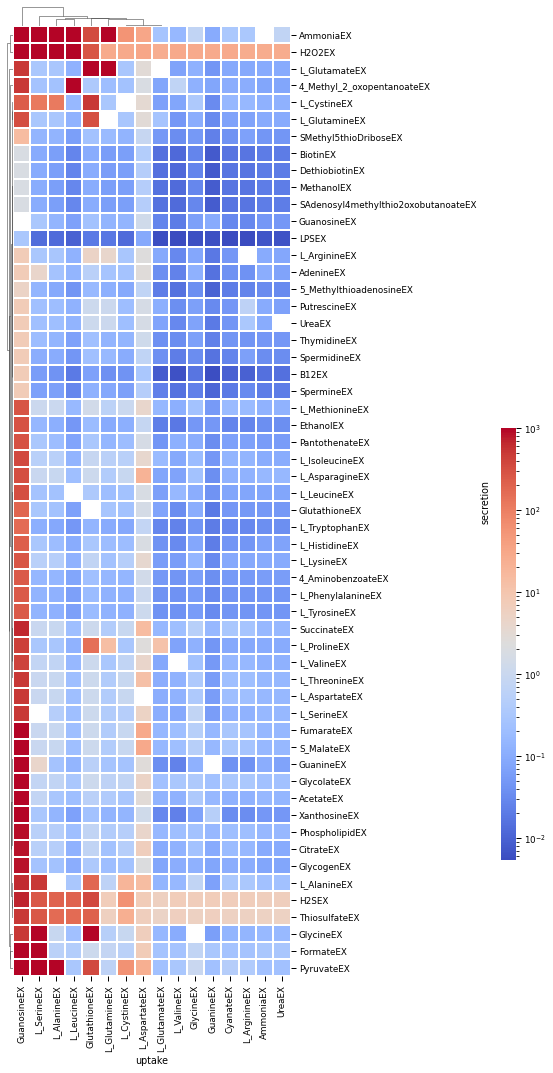

In [197]:
from matplotlib.colors import LogNorm, Normalize
drop_columns = ["tRNAEX", 'CadaverineEX', 'CadmiumEX','CalciumEX', 'ChlorideEX', 'CalciumEX', 'ChlorideEX',
                'IronEX','MagnesiumEX', 'PotassiumEX', 'SelenateEX', 'SodiumEX', 'StrontiumEX', 'ZincEX', 'R00024',
                'H2OEX', "HEX", 'BiomassEX', 'CO2EX', 'O2EX']
remove_from_list = ['HEX', 'H2OEX']
sns.set_context('paper')
pdf = force_feeding_df.loc[(force_feeding_df.maximum > 1e-3) & (~force_feeding_df.secretion.isin(drop_columns))
                          ].pivot_table(columns='uptake', index='secretion', values='maximum', fill_value=0)
sns.clustermap(pdf, norm=LogNorm(), 
               cmap='coolwarm', figsize=(7,15), 
               linewidths=0.1, #cbar_kws= dict(location='right'),
              robust=True, cbar_pos=(1, .2, .03, .4),
              dendrogram_ratio=0.02)
plt.tight_layout()